# Combining Glove and trained Gensim Word2vec

Pre-trained Glove word vectors can be downloaded here:

http://nlp.stanford.edu/data/glove.6B.zip

## Building the Glove embeddings index

Loading the word vectors is pretty straight forward:

In [1]:
import os
import numpy as np

GLOVE_DIR = 'glove/'

glove_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_index))

Found 400000 word vectors.


## Loading the training and testing set

For training we will use the well known 20 newsgroups dataset.

In [2]:
import re
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'soc.religion.christian','comp.graphics','sci.med']

train_set = fetch_20newsgroups(subset='train',
                           categories=categories,
                           remove=('headers', 'footers', 'quotes'),
                           shuffle=True, 
                           random_state=42)

test_set = fetch_20newsgroups(subset='test',                          
                          categories=categories,
                          remove=('headers', 'footers', 'quotes'),
                          shuffle=True, 
                          random_state=42)

all_set_data = train_set.data + test_set.data

print("All documents: %d"%(len(all_set_data)))
print("Train documents: %d"%(len(train_set.data)))
print("Test documents: %d"%(len(test_set.data)))

All documents: 3759
Train documents: 2257
Test documents: 1502


## Building the Gensim Word2vec index

In [4]:
def clean(text):
    """Remove posting header, split by sentences and words, keep only letters"""
    lines = re.split('[?!.:]\s', re.sub('^.*Lines: \d+', '', re.sub('\n', ' ', text)))
    return [re.sub('[^a-zA-Z]', ' ', line).lower().split() for line in lines]

sentences = [line for text in train_set.data for line in clean(text)]

print("Number of sentences: %d"%len(sentences))

from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences, workers=4, size=100, min_count=32, window=16, sample=1e-3)

wv = model.wv
voc = model[model.wv.vocab]
del model

gensim_index = {w: vec for w, vec in zip(wv.index2word, wv.syn0)}

print('Found %s word vectors.' % len(gensim_index))

Number of sentences: 31610
Found 1583 word vectors.


## Combine the two models

In [5]:
embeddings_index = {}

gensim_size = len(next(iter(gensim_index.values())))
glove_size = len(next(iter(glove_index.values())))

for gkey, gvalue in glove_index.items():
    if gkey in gensim_index:
        embeddings_index[gkey] = np.append(gvalue, gensim_index[gkey])
    else:
        embeddings_index[gkey] = np.append(gvalue, np.zeros(gensim_size))

for genkey, genvalue in gensim_index.items():
    if genkey not in embeddings_index:
        embeddings_index[genkey] = np.append(genvalue, np.zeros(glove_size))
        
print('Embedding index has %s word vectors.' % len(embeddings_index))

Embedding index has 400005 word vectors.


## Define the embedding vectorizer

We will define a Vectorizer class to be used with our pipeline. 

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict

class EmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(next(iter(word2vec.values())))
        
    def fit(self, X, y):
        return self
        
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                        for texts in X])

## Support Vector Machine classifier

We will build a pipeline using our vectorizer and the SVM classifier (SVC) with a linear kernel.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

text_clf = Pipeline([('vectorizer', EmbeddingVectorizer(embeddings_index)),
                     ('clf', SVC(kernel="linear"))
])

text_clf.fit(train_set.data, train_set.target)
predicted = text_clf.predict(test_set.data)

print("Accuracy on the test set: %.2f%%" % (np.mean(predicted == test_set.target) * 100))

Accuracy on the test set: 74.90%


## Comparison with Bag of words approach

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

text_clf = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                     ('clf', SVC(kernel="linear"))
])

text_clf.fit(train_set.data, train_set.target)
predicted = text_clf.predict(test_set.data)

print("Accuracy on the test set: %.2f%%" % (np.mean(predicted == test_set.target) * 100))

Accuracy on the test set: 80.23%


## Convolutional neural network in Keras

In [10]:
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Prepare input embeddings and transform labels to binary class matrices:

In [11]:
vect = EmbeddingVectorizer(embeddings_index)
vect.fit(train_set.data, None)

x_train = vect.transform(train_set.data)
x_test = vect.transform(test_set.data)

y_train = to_categorical(train_set.target) 
y_test = to_categorical(test_set.target)


x_train = np.reshape(x_train, (x_train.shape[0], 200, 1))
x_test = np.reshape(x_test, (x_test.shape[0], 200, 1))

x_train.shape

(2257, 200, 1)

Define the CNN model:

In [28]:
model = Sequential()

model.add(Conv1D(64, 3, activation='relu', input_shape=(200,1)))
model.add(MaxPooling1D(3))

model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D(4))

model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalAveragePooling1D())

model.add(Dropout(0.3))
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 198, 64)           256       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 66, 64)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 63, 64)            16448     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 15, 64)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 11, 32)            10272     
_________________________________________________________________
global_average_pooling1d_4 ( (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
__________

Now let's train the model an check the accuracy:

In [29]:
%%time

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=300,
          shuffle=True,
          verbose=0,
          validation_data=(x_test, y_test))

print('Training done.')

scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Training done.
Accuracy: 65.38%
Wall time: 4min 33s


Visualize the accuracy:

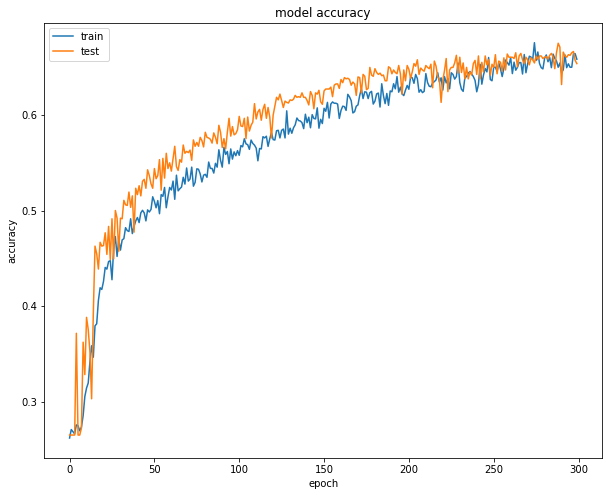

In [30]:
# summarize history for accuracy
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Visualize the loss:

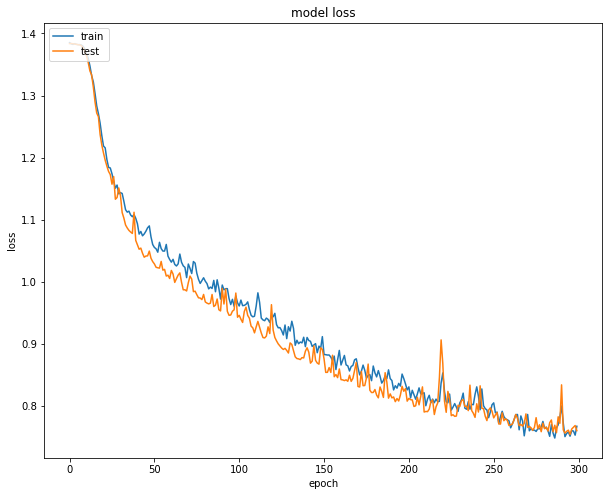

In [31]:
# summarize history for loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Check the accuracy

Keras evaluate function sometimes outputs incorrect results so we should check again using predicted output.

In [32]:
predicted = model.predict(x_test)
print("Accuracy: %.2f%%" % (np.mean(np.equal(np.argmax(predicted, axis=-1), np.argmax(y_test, axis=-1))) * 100))

Accuracy: 65.38%
